In [1]:
import ingestor, modeller, fitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from cycler import cycler

new_color = cycler(color=["k"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [4]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)

<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [5]:
context = ingestor.Context("runs/minimal4.3.run")

In [6]:
model = modeller.Model(context)

In [7]:
solver = fitter.Fitter()
solver.construct_objectives(context, model)

In [8]:
solver.construct_problems()

In [9]:
for rhoi in np.logspace(-6, 4, num=51):
    solver.solve(rhoi)
    solver.problems[0].initial_guess = solver.solutions[str(rhoi)][-1].x

In [10]:
solver.solutions

{'1e-06': [      fun: 0.00868834119698069
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-4.04895480e-10,  4.15046537e-10,  2.69256603e-10, -5.22730125e-10,
         -3.10503026e-09,  1.17769057e-08,  5.00999446e-09,  1.80400627e-09,
         -7.97401485e-09,  2.51240687e-09,  1.65404353e-09])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 3
        nit: 2
     status: 0
    success: True
          x: array([1.00000005, 0.99999999, 0.99999994, 1.0000001 , 0.99999988,
         1.00000052, 1.00000024, 0.99999964, 0.99999985, 1.00000043,
         0.99999952])],
 '1.584893192461114e-06': [      fun: 0.00868834119698069
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-4.08235749e-10,  4.16398807e-10,  2.58839815e-10, -5.00912145e-10,
         -3.12069887e-09,  1.18144422e-08,  5.04460921e-09,  1.71398481e-09,
         -7.88645296e-09,  2.54528842e-09,  1.69072715e-09])
    message: b'CONVERGENCE:

# Validation

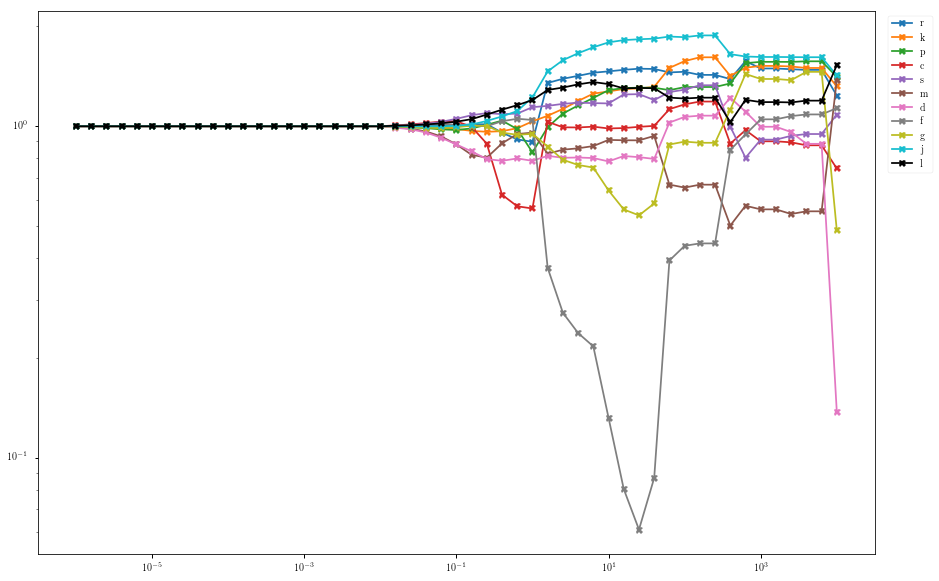

In [11]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("rkpcsmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

Text(0, 0.5, 'Number')

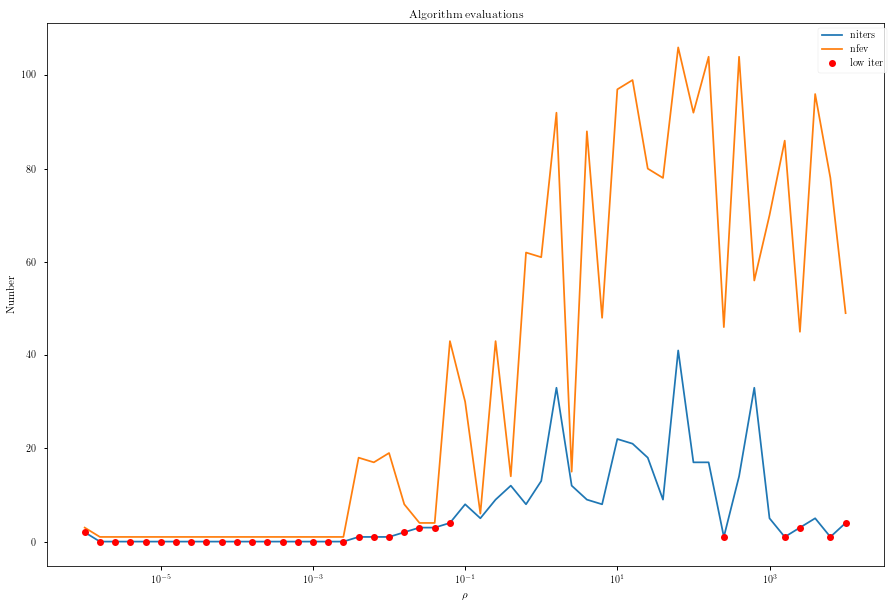

In [12]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 5])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

In [13]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [model.ts, *model.cs], model.xs)
    

[1.47900963 1.2944968  1.30362356 0.98735012 1.24681178 0.90724007
 0.81330822 0.08058298 0.56128934 1.81807104 1.30021822]
[[ 0.00088955 -0.01347749 -0.73613146]]


Text(0.5, 0, 'time, t')

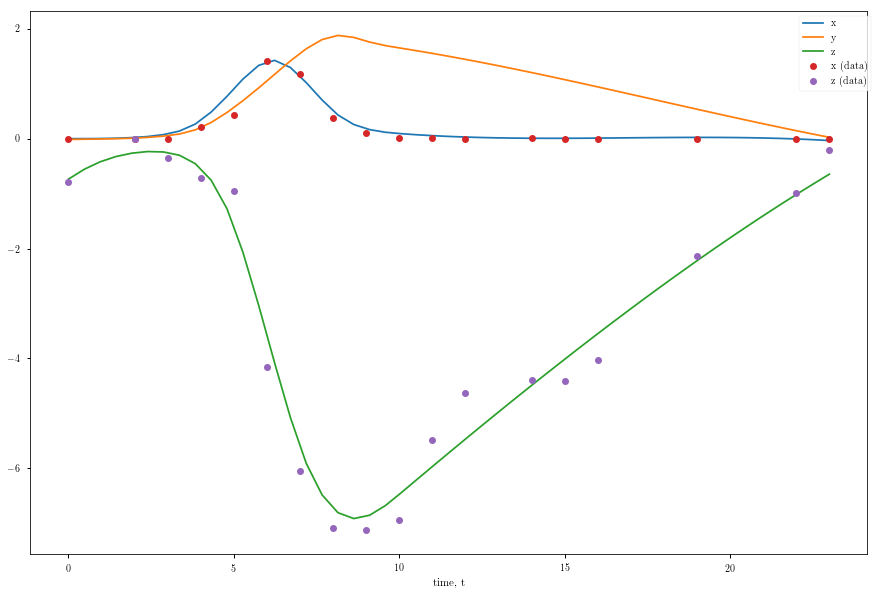

In [52]:
target_rho = 15.848931924611142
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x
print(solver.solutions[str(target_rho)][0].x)
xs_end = np.array([np.array(i) for i in getx(model.observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])
print(xs_end[:,0].T)
plt.plot(model.observation_times, np.hstack([xs_end[0], xs_end[1], xs_end[2]]),
         context.datasets[0]['t'], context.datasets[0]['x'], 'o',
         context.datasets[0]['t'], context.datasets[0]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

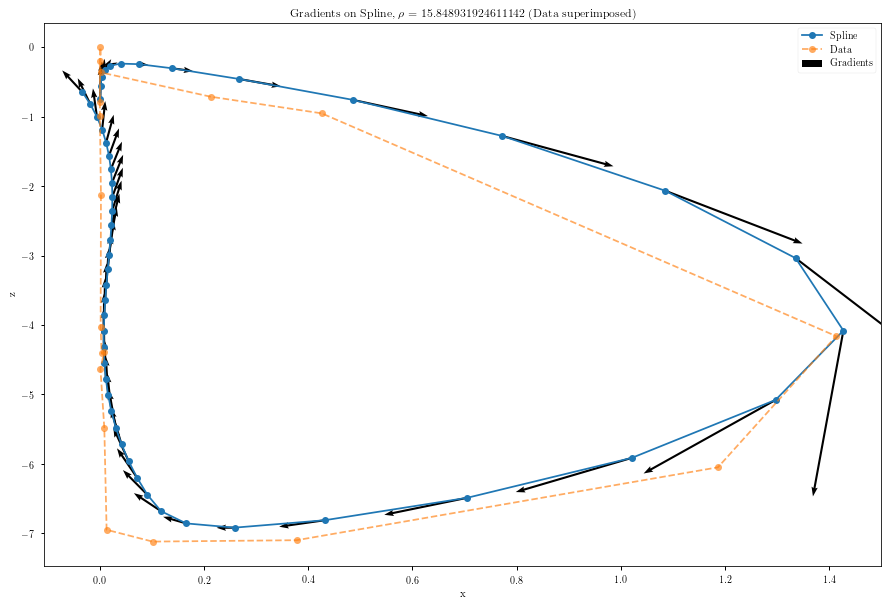

In [53]:
spline_dfield = np.array([context.model(t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(model.observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])

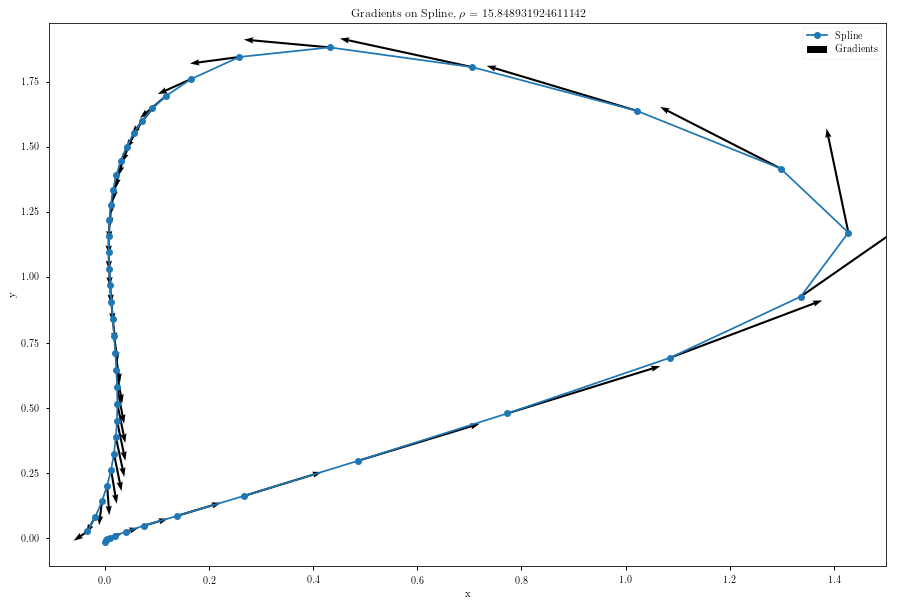

In [54]:
plt.plot(xs_end[0], xs_end[1], 'o-')
plt.quiver(xs_end[0], xs_end[1], spline_dfield[:,0], spline_dfield[:,1], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Spline", "Gradients"])

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

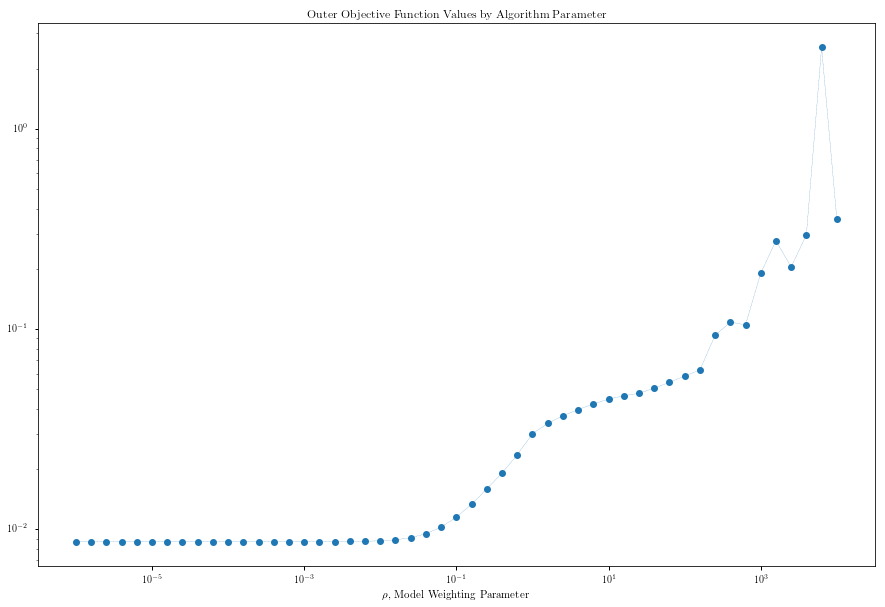

In [19]:
outer_objective_values = np.array([[float(rho), val[0].fun] for rho, val in solver.solutions.items()])
plt.loglog(*outer_objective_values.T, 'o--', linewidth=0.25)
plt.title("Outer Objective Function Values by Algorithm Parameter")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

In [20]:
inner_objective_values = np.array([[r, solver.problems[0].cache.results[tokey(r, v)].fun] for r,v in zip(rhos, vals)])
dfield = np.abs(np.hstack([np.array(rhos).reshape(-1,1), 
                           ((inner_objective_values - outer_objective_values)[:,1] / rhos).reshape(-1,1)]))


Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

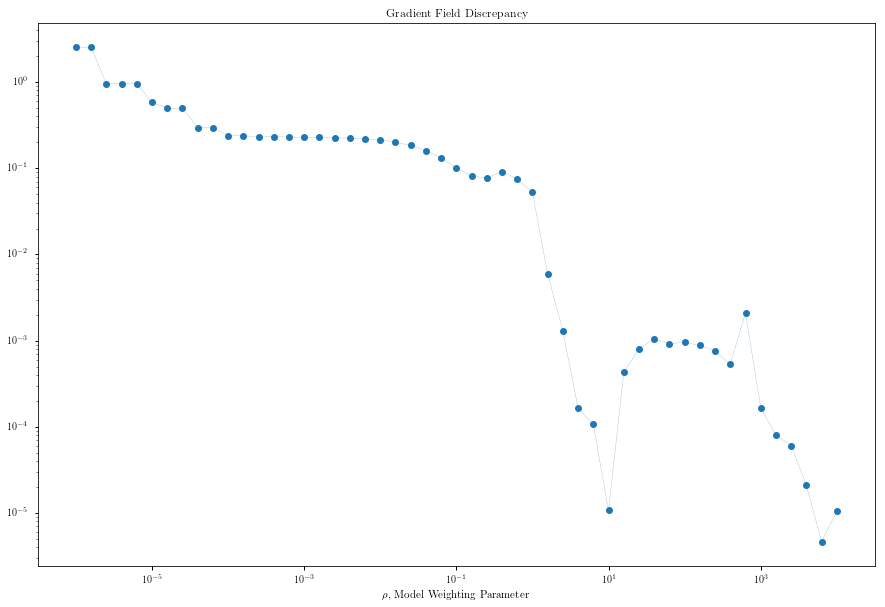

In [21]:
plt.loglog(*dfield.T, 'o--', linewidth=0.25)
plt.title("Gradient Field Discrepancy")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

Text(0, 0.5, 'Diff Field')

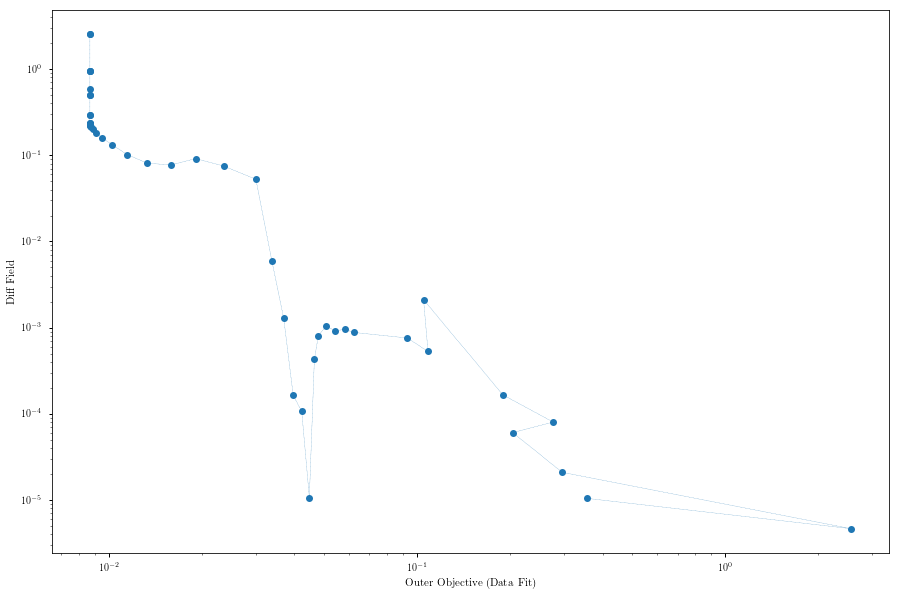

In [22]:
plt.loglog(outer_objective_values[:,1], dfield[:,1], '--o', linewidth=0.25)
plt.xlabel("Outer Objective (Data Fit)")
plt.ylabel("Diff Field")

Text(0, 0.5, '$\\kappa$')

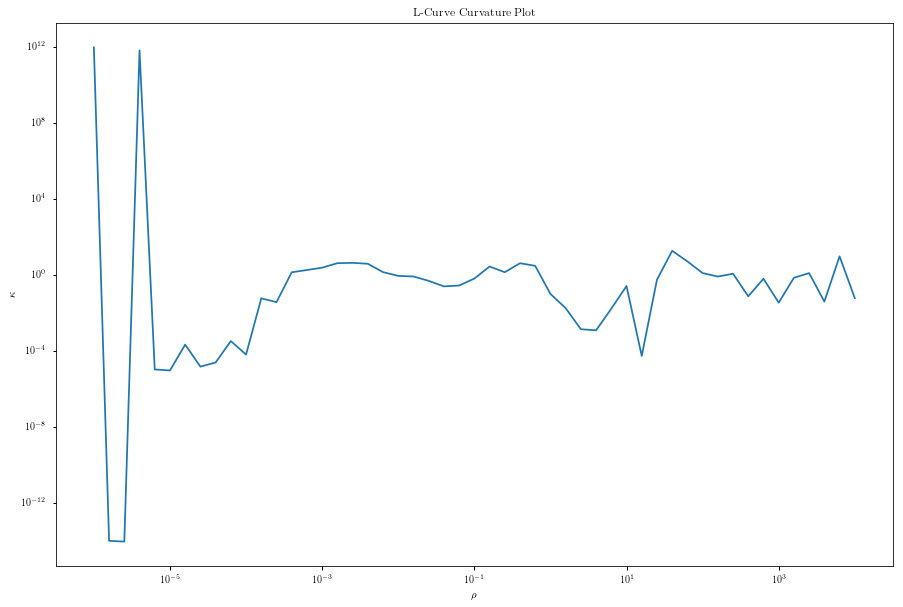

In [23]:
curv_dx = np.gradient(np.log(outer_objective_values[:,1]))
curv_dy = np.gradient(np.log(dfield[:,1]))
curv_dx2 = np.gradient(curv_dx)
curv_dy2 = np.gradient(curv_dy)

kappa = np.abs(curv_dx*curv_dy2 - curv_dy*curv_dx2)/(curv_dx**2 + curv_dy**2)**(3/2)

plt.loglog(rhos, kappa)
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\kappa$")

## Odd Validation

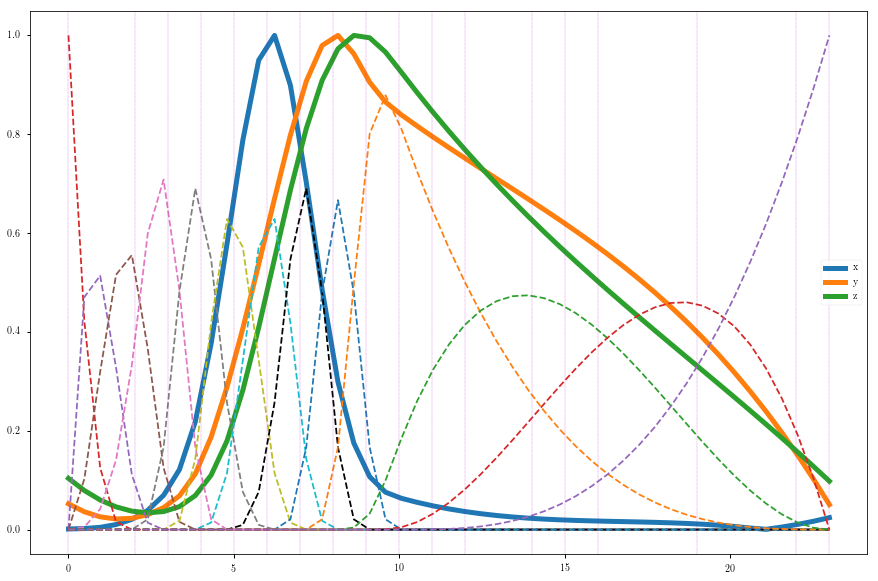

In [24]:
bfn = modeller.ca.Function('basis_fns', [model.ts], [model.basis])
plt.plot(model.observation_times, np.abs(np.hstack([xs_end[0]/max(abs(xs_end[0])), 
                                             xs_end[1]/max(abs(xs_end[1])), 
                                             xs_end[2]/max(abs(xs_end[2]))])),
         linewidth=5)
plt.plot(model.observation_times, bfn(model.observation_times), '--')
plt.legend('xyz')
[plt.axvline(x=i, color='m', linewidth=0.25, linestyle='--') for i in context.datasets[0]['t']]
print("")

In [25]:
# generate a crude correlation plot

import pandas as pd

results = pd.DataFrame({r"$\rho$": np.log(rhos)})
for idx, name in enumerate("rkpcsmdfgjl"):
    results[name] = [v[idx] for v in vals]
    

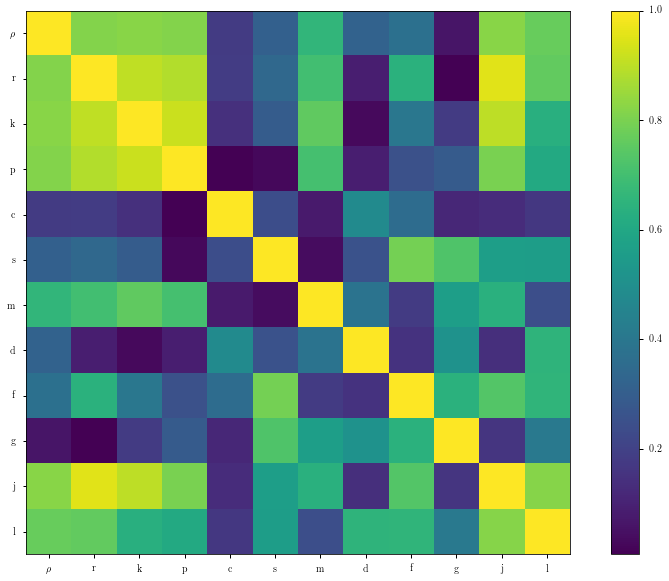

In [26]:
plt.imshow(np.abs(results.corr()))
plt.colorbar()
plt.xticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.yticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.grid(False)

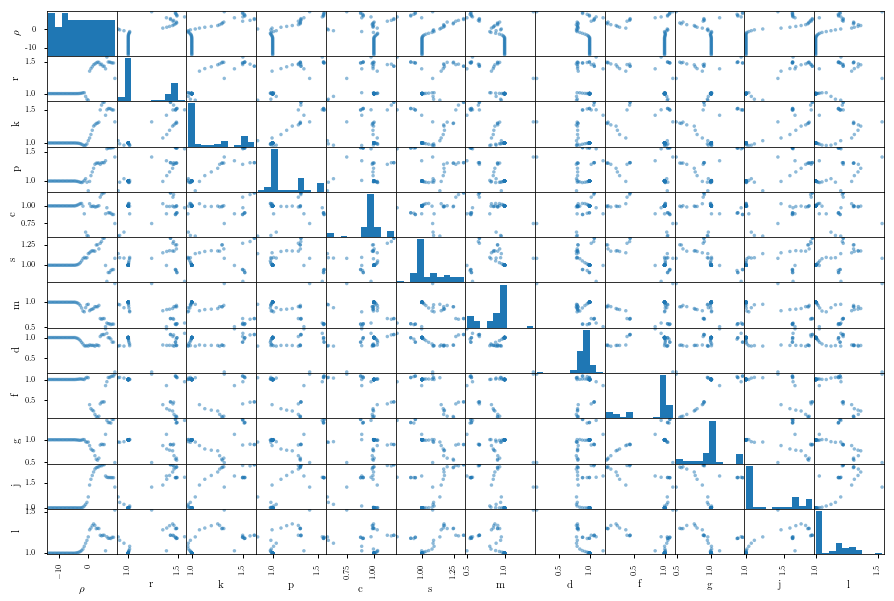

In [27]:
ax = pd.plotting.scatter_matrix(results)
for a in ax.flatten():
    a.grid(False)

## Smoothing Experiments

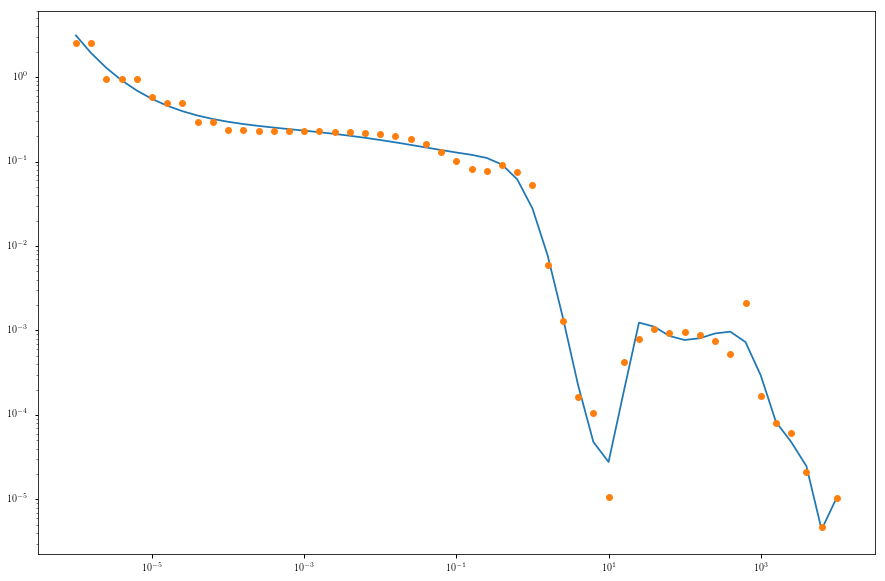

In [55]:
from scipy import interpolate

smooth_dfield = interpolate.UnivariateSpline(np.log(rhos), np.log(dfield[:,1]), s=6, k=4)

sfield =  np.exp(smooth_dfield(np.log(rhos)))

plt.loglog(rhos, sfield, rhos, dfield[:,1], 'o')

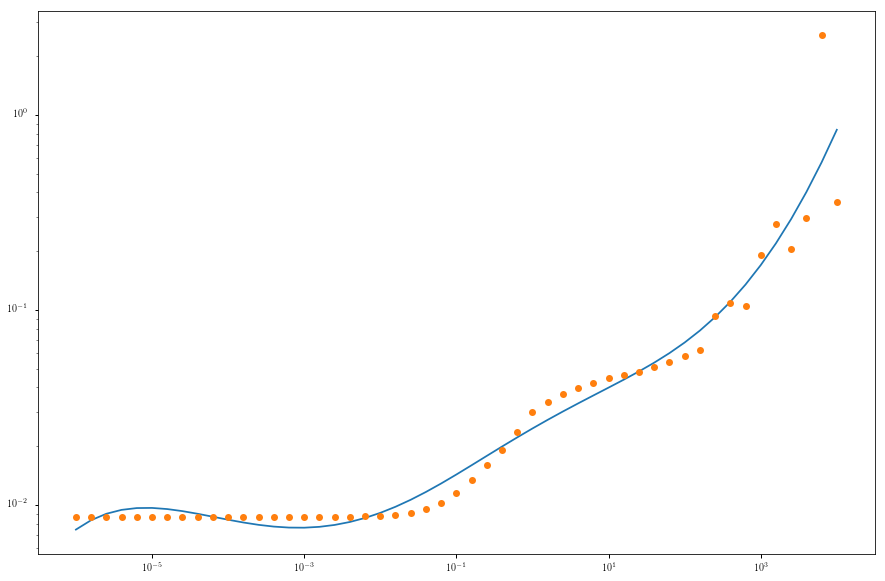

In [46]:
smooth_outer = interpolate.UnivariateSpline(np.log(rhos), np.log(outer_objective_values[:,1]), s=4, k=4)
souter = np.exp(smooth_outer(np.log(rhos)))
plt.loglog(rhos, souter, rhos, outer_objective_values[:,1], 'o')

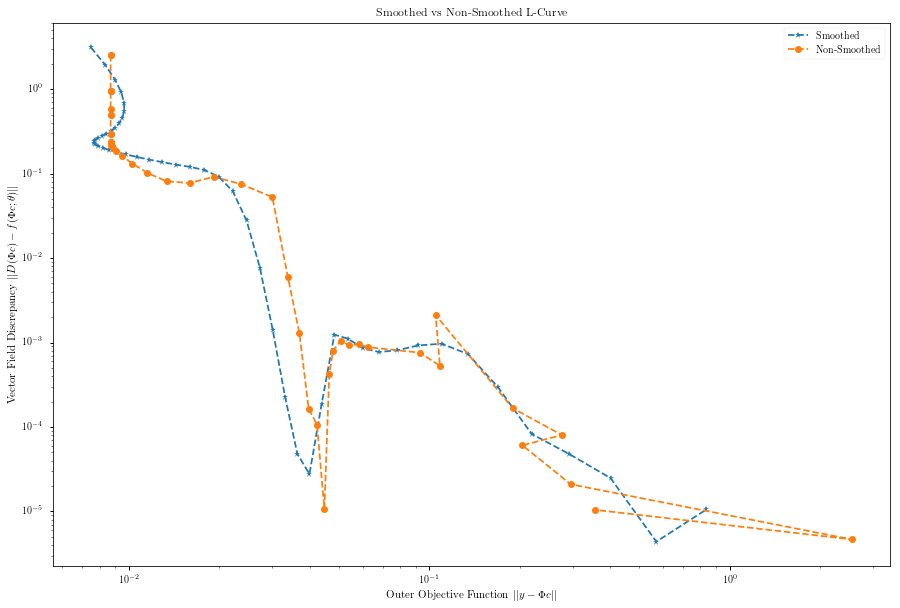

In [56]:
plt.loglog(souter, sfield, '*--', outer_objective_values[:,1], dfield[:,1], 'o--')
plt.title("Smoothed vs Non-Smoothed L-Curve")
plt.xlabel(r"Outer Objective Function $||y-{\Phi}c||$")
plt.ylabel(r"Vector Field Discrepancy $||D({\Phi}c) - f({\Phi}c; \theta)||$")
plt.legend(["Smoothed", "Non-Smoothed"])

Text(0, 0.5, '$\\kappa$')

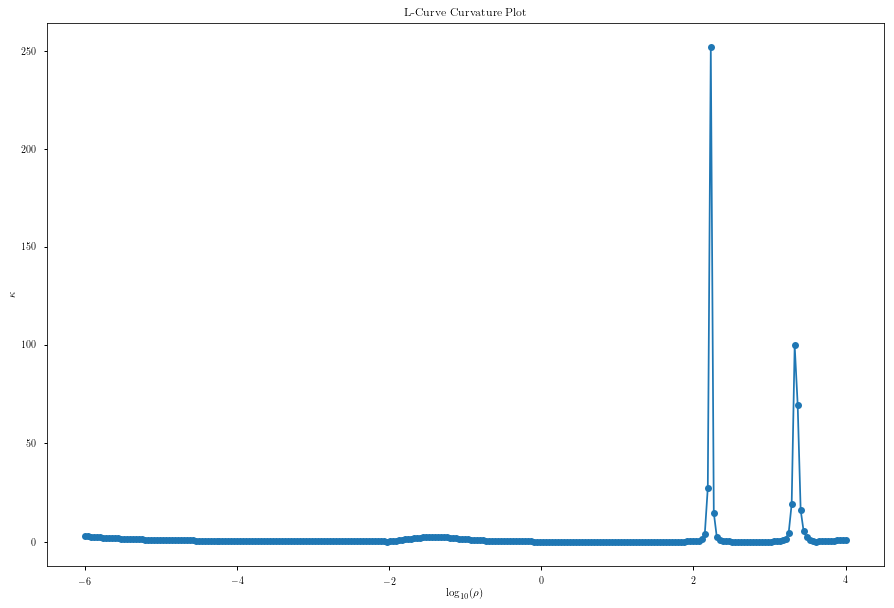

In [57]:
# ? curvature
f_dx = smooth_outer.derivative(1)
f_dy = smooth_dfield.derivative(1)
f_dx2 = smooth_outer.derivative(2)
f_dy2 = smooth_dfield.derivative(2)

rhos_log_finer = np.linspace(np.log10(rhos[0]), np.log10(rhos[-1]), len(rhos)*5)

scurv_dx = f_dx(rhos_log_finer)
scurv_dy = f_dy(rhos_log_finer)
scurv_dx2 = f_dx2(rhos_log_finer)
scurv_dy2 = f_dy2(rhos_log_finer)

kappa_fine = np.abs(scurv_dx*scurv_dy2 - scurv_dy*scurv_dx2)/(scurv_dx**2 + scurv_dy**2)**(3/2)

plt.plot(rhos_log_finer, kappa_fine, 'o-')
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

Text(0, 0.5, '$\\kappa$')

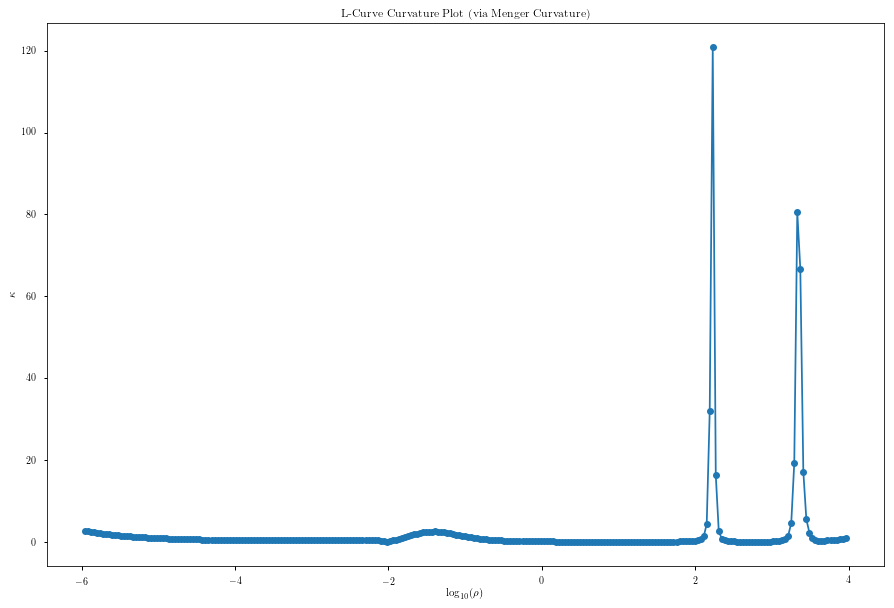

In [58]:
# menger curvature
curvs = []

sx = smooth_outer(rhos_log_finer)
sy = smooth_dfield(rhos_log_finer)

for idx in range(1, len(rhos_log_finer)-1):
    xs = sx[idx-1:idx+2]
    ys = sy[idx-1:idx+2]
    ps = np.vstack([xs,ys]).T
    curvs.append(2*np.abs(np.cross(ps[1] - ps[0], ps[2]-ps[1]))/(
            np.linalg.norm(ps[0]-ps[1])*np.linalg.norm(ps[1]-ps[2])*np.linalg.norm(ps[2]-ps[0])))

plt.plot(rhos_log_finer[1:-1], np.array(curvs), 'o-')
plt.title("L-Curve Curvature Plot (via Menger Curvature)")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

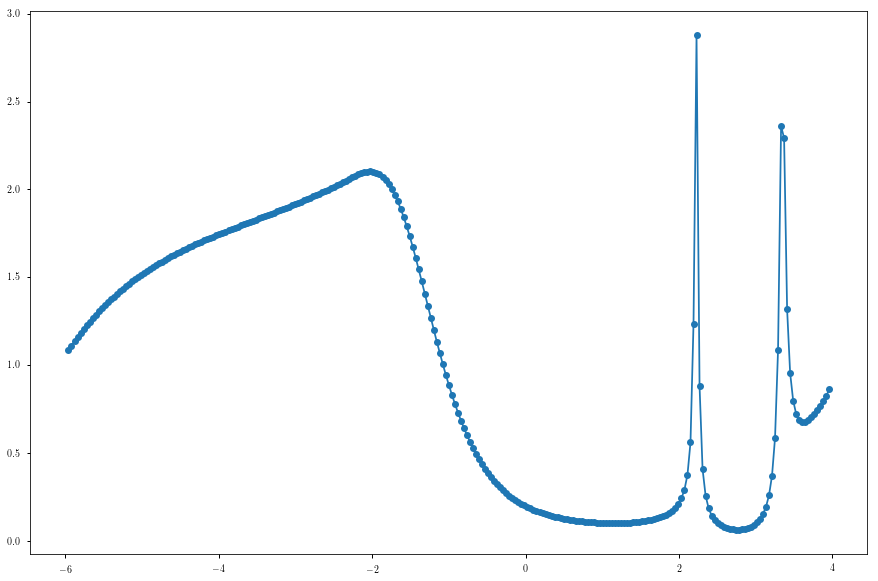

In [59]:
# straight up cosines

xkm1 = sx[0:-2] - sx[1:-1]
xkp1 = sx[2:] - sx[1:-1]
ykm1 = sy[0:-2] - sy[1:-1]
ykp1 = sy[2:] - sy[1:-1]
raw_angles = (xkm1*xkp1 - ykp1*ykm1) / (np.sqrt(xkm1**2 + ykm1**2)*np.sqrt(xkp1**2 + ykp1**2))
angles = np.arccos(raw_angles)
cosR = np.sqrt((np.hypot(xkp1, ykp1)**2+np.hypot(xkm1,ykm1)**2 - 2*np.hypot(xkp1, ykp1)*np.hypot(xkm1,ykm1)*raw_angles)/
               (4*(1-raw_angles**2)))
plt.plot(rhos_log_finer[1:-1], angles, 'o-')

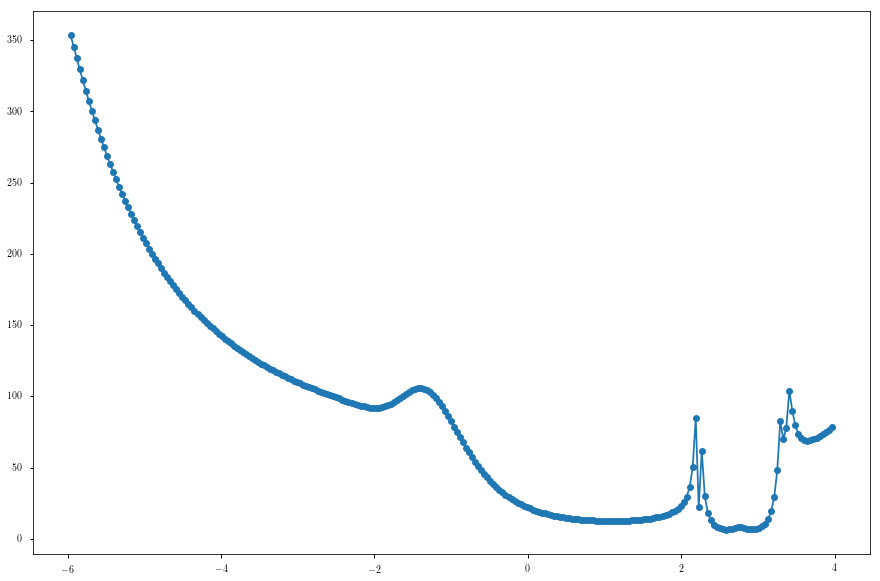

In [60]:
plt.plot(rhos_log_finer[1:-1], 1/cosR, 'o-')

In [15]:
rhos

[1e-06,
 1.584893192461114e-06,
 2.5118864315095823e-06,
 3.981071705534969e-06,
 6.30957344480193e-06,
 1e-05,
 1.584893192461114e-05,
 2.5118864315095822e-05,
 3.9810717055349695e-05,
 6.309573444801929e-05,
 0.0001,
 0.00015848931924611142,
 0.0002511886431509582,
 0.00039810717055349735,
 0.0006309573444801936,
 0.001,
 0.001584893192461114,
 0.002511886431509582,
 0.003981071705534973,
 0.006309573444801936,
 0.01,
 0.01584893192461114,
 0.025118864315095822,
 0.039810717055349776,
 0.06309573444801943,
 0.1,
 0.15848931924611143,
 0.25118864315095824,
 0.39810717055349776,
 0.6309573444801942,
 1.0,
 1.584893192461114,
 2.5118864315095824,
 3.9810717055349776,
 6.309573444801943,
 10.0,
 15.848931924611142,
 25.11886431509582,
 39.81071705534978,
 63.09573444801943,
 100.0,
 158.48931924611173,
 251.18864315095823,
 398.1071705534969,
 630.9573444801943,
 1000.0,
 1584.8931924611175,
 2511.886431509582,
 3981.0717055349855,
 6309.573444801943,
 10000.0]